In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

from matplotlib import pyplot as plt
import pytz
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler

import networkx as nx
from scipy.sparse import csr_matrix, lil_matrix

from time import time



from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from tqdm import tqdm

from scipy.spatial.distance import pdist, squareform


import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')  # Adjust the path

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/new_data_preprocessed.csv')

In [ ]:
dataset

,Start_datetime,End_datetime,Volume (kWh),Charge_Point_ID,max P per EVSE (kW),Dur_float,Charging_time,Idle_time
0,0.174974,0.460698,0.097789,0000002411,0.000000,0.533854,0.102978,0.533849
1,0.306722,0.048490,0.156462,0000002343,0.000000,0.618000,0.164765,0.617991
2,0.665729,0.156636,0.758690,0000002207,0.000000,0.466378,0.798951,0.466329
3,0.692941,0.037943,0.126233,0000002487,0.000000,0.212909,0.132932,0.212901
4,0.791127,0.000115,0.035747,0000002255,0.000000,0.042902,0.037644,0.042900
...,...,...,...,...,...,...,...,...
53128,0.678172,0.454358,0.016149,T54HU10321013,0.285714,0.020170,0.007482,0.020170
53129,0.716641,0.472716,0.359898,T124IT10521065,1.000000,0.016831,0.069483,0.016827
53130,0.731864,0.500696,0.045258,0000002193,0.000000,0.055027,0.047660,0.055024
53131,0.792080,0.505492,0.048345,T124IT10521065,1.000000,0.004150,0.009334,0.004150


In [ ]:
dataset = dataset.drop(["Charge_Point_ID"], axis = 1)

In [ ]:
 #KMeans++, K-Medoids και BIRCH

In [ ]:
#One disadvantage of the K-means algorithm is that it is sensitive to the initialization of the centroids or the mean points.
#To overcome the above-mentioned drawback we use K-means++. This algorithm ensures a smarter initialization of the centroids
#and improves the quality of the clustering. Apart from initialization, the rest of the algorithm is the same as the standard K-means algorithm.
#That is K-means++ is the standard K-means algorithm coupled with a smarter initialization of the centroids.

def kmeans_plus_plus(X, k):
    """
    Performs K-Means++ initialization to select initial centroids.

    Args:
    X (numpy.ndarray): Data points
    k (int): Number of clusters

    Returns:
    numpy.ndarray: Initial centroids
    """
    n = X.shape[0]
    centroids = np.zeros((k, X.shape[1]))

    # Choose first centroid randomly
    centroids[0] = X[np.random.choice(n)]

    # Compute distances to the nearest centroid for each point
    distances = np.full(n, float('inf'))

    for i in range(1, k):
        for j in range(n):
            dist = np.linalg.norm(X[j] - centroids[i-1])
            if dist < distances[j]:
                distances[j] = dist

        # Select next centroid using weighted probability
        probs = distances**2 / np.sum(distances**2)
        centroids[i] = X[np.random.choice(n, p=probs)]

    return centroids


In [ ]:
import numpy as np

def kmeans(X, initial_centroids, max_iterations=100, tolerance=1e-4):
    """
    Performs K-Means clustering on the given data points.

    Args:
    X (numpy.ndarray): Data points
    initial_centroids (numpy.ndarray): Initial centroids
    max_iterations (int): Maximum number of iterations
    tolerance (float): Convergence tolerance

    Returns:
    numpy.ndarray: Final centroids
    numpy.ndarray: Cluster assignments for each data point
    """
    n = X.shape[0]
    k = initial_centroids.shape[0]
    centroids = initial_centroids.copy()

    for _ in range(max_iterations):
        # Assign each data point to the nearest centroid
        cluster_assignments = np.zeros(n, dtype=int)
        for i in range(n):
            min_distance = float('inf')
            for j in range(k):
                distance = np.linalg.norm(X[i] - centroids[j])
                if distance < min_distance:
                    min_distance = distance
                    cluster_assignments[i] = j

        # Update centroids
        new_centroids = np.zeros_like(centroids)
        cluster_counts = np.zeros(k, dtype=int)
        for i in range(n):
            new_centroids[cluster_assignments[i]] += X[i]
            cluster_counts[cluster_assignments[i]] += 1
        for j in range(k):
            if cluster_counts[j] > 0:
                new_centroids[j] /= cluster_counts[j]

        # Check for convergence
        if np.max(np.abs(new_centroids - centroids)) < tolerance:
            break
        centroids = new_centroids

    return centroids, cluster_assignments


In [ ]:
X=np.array(dataset[:50000])

In [ ]:
# Run K-Means++ initialization
k = 10
initial_centroids = kmeans_plus_plus(X, k)

# Run K-Means algorithm
final_centroids, cluster_assignments = kmeans(X, initial_centroids)

print("Final centroids:")
print(final_centroids)
print("Cluster assignments:")
print(cluster_assignments)


Final centroids:
[[3.28945202e-01 2.83131841e-01 5.75812701e-02 0.00000000e+00
  4.17626448e-02 6.06369074e-02 4.17591680e-02]
 [6.50185251e-01 2.83440562e-01 3.14753268e-01 1.48654675e-03
  5.58063610e-01 3.29680515e-01 5.58044747e-01]
 [6.21100413e-01 4.15262624e-01 7.74264013e-02 0.00000000e+00
  5.57410217e-02 8.15351504e-02 5.57362841e-02]
 [6.35583782e-01 4.22122111e-01 4.37914661e-01 4.71908560e-01
  3.47080034e-02 1.57052695e-01 3.46985303e-02]
 [3.11024279e-01 3.44216182e-01 1.48062848e-01 4.00801603e-04
  1.82928085e-01 1.55728741e-01 1.82919066e-01]
 [4.78237572e-01 3.45272509e-01 2.90728561e-01 1.00000000e+00
  2.46737084e-02 5.61286940e-02 2.46704682e-02]
 [6.38568047e-01 4.25241549e-01 1.25846904e-01 3.51243772e-01
  3.08292674e-02 5.32918078e-02 3.08262185e-02]
 [3.17673640e-01 2.74470265e-01 4.50536908e-01 4.69407678e-01
  3.64747757e-02 1.62261177e-01 3.64649841e-02]
 [3.21941262e-01 2.74892518e-01 1.16079760e-01 3.60517115e-01
  3.39127004e-02 4.82432285e-02 3.3909972

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, cluster_assignments)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.3223364068201285


In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(X, cluster_assignments)
print("Calinski-Harabasz Index:", ch_score)


Calinski-Harabasz Index: 6195.404483658322


In [ ]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X, cluster_assignments)
print("Davies-Bouldin Index:", db_score)


Davies-Bouldin Index: 1.0510033116308253


In [ ]:
X.shape

(50000, 7)

Cluster 0: 38388 elements
Cluster 1: 11612 elements
Silhouette score for k=2: 0.3885661339531027
Cluster 0: 33368 elements
Cluster 1: 11445 elements
Cluster 2: 5187 elements
Silhouette score for k=3: 0.39130229696775176
Cluster 0: 17320 elements
Cluster 1: 4264 elements
Cluster 2: 10005 elements
Cluster 3: 18411 elements
Silhouette score for k=4: 0.3142356648031503
Cluster 0: 14886 elements
Cluster 1: 7553 elements
Cluster 2: 17265 elements
Cluster 3: 4162 elements
Cluster 4: 6134 elements
Silhouette score for k=5: 0.30577715786564813
Cluster 0: 5012 elements
Cluster 1: 4069 elements
Cluster 2: 3832 elements
Cluster 3: 15355 elements
Cluster 4: 15705 elements
Cluster 5: 6027 elements
Silhouette score for k=6: 0.3169012255505268
Cluster 0: 4407 elements
Cluster 1: 14515 elements
Cluster 2: 5213 elements
Cluster 3: 3929 elements
Cluster 4: 1287 elements
Cluster 5: 5206 elements
Cluster 6: 15443 elements
Silhouette score for k=7: 0.3352570496161795
Cluster 0: 1597 elements
Cluster 1: 1287

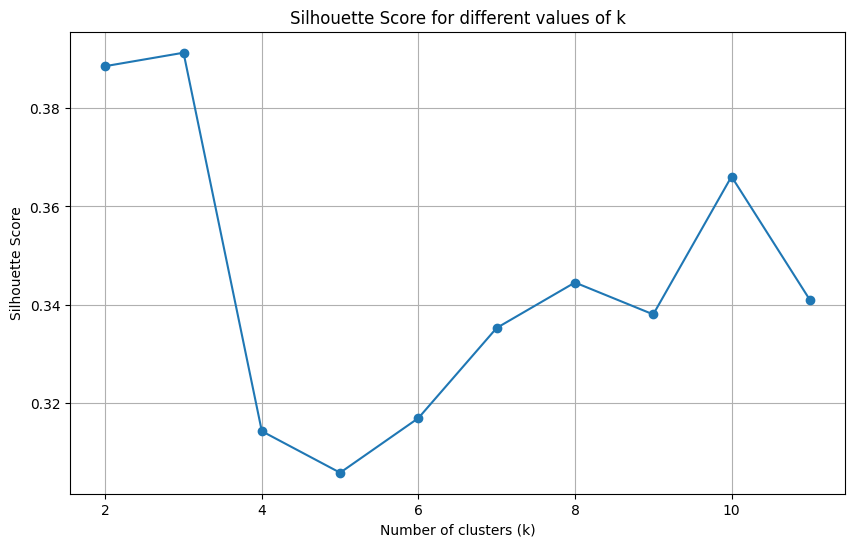

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def grid_search_kmeans(X, k_range):
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        cluster_assignments = kmeans.fit_predict(X)

        # Count the number of elements in each cluster
        cluster_counts = Counter(cluster_assignments)

        # Print the number of elements in each cluster
        for cluster_id, count in sorted(cluster_counts.items()):
            print(f"Cluster {cluster_id}: {count} elements")

        score = silhouette_score(X, cluster_assignments)
        silhouette_scores.append(score)
        print(f"Silhouette score for k={k}: {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for different values of k')
    plt.grid(True)
    plt.show()

    return silhouette_scores

# Define the range of k values
k_range = range(2, 12)

# Assuming X is your dataset loaded as a numpy array
# Example: X = np.array([...])

# Perform grid search and plot silhouette scores
silhouette_scores = grid_search_kmeans(X, k_range)

Cluster 0: 38388 elements
Cluster 1: 11612 elements
Silhouette score for k=2: 0.3885661339531027
Cluster 0: 33368 elements
Cluster 1: 11445 elements
Cluster 2: 5187 elements
Silhouette score for k=3: 0.39130229696775176
Cluster 0: 17320 elements
Cluster 1: 4264 elements
Cluster 2: 10005 elements
Cluster 3: 18411 elements
Silhouette score for k=4: 0.3142356648031503
Cluster 0: 14886 elements
Cluster 1: 7553 elements
Cluster 2: 17265 elements
Cluster 3: 4162 elements
Cluster 4: 6134 elements
Silhouette score for k=5: 0.30577715786564813
Cluster 0: 5012 elements
Cluster 1: 4069 elements
Cluster 2: 3832 elements
Cluster 3: 15355 elements
Cluster 4: 15705 elements
Cluster 5: 6027 elements
Silhouette score for k=6: 0.3169012255505268
Cluster 0: 4407 elements
Cluster 1: 14515 elements
Cluster 2: 5213 elements
Cluster 3: 3929 elements
Cluster 4: 1287 elements
Cluster 5: 5206 elements
Cluster 6: 15443 elements
Silhouette score for k=7: 0.3352570496161795
Cluster 0: 1597 elements
Cluster 1: 1287

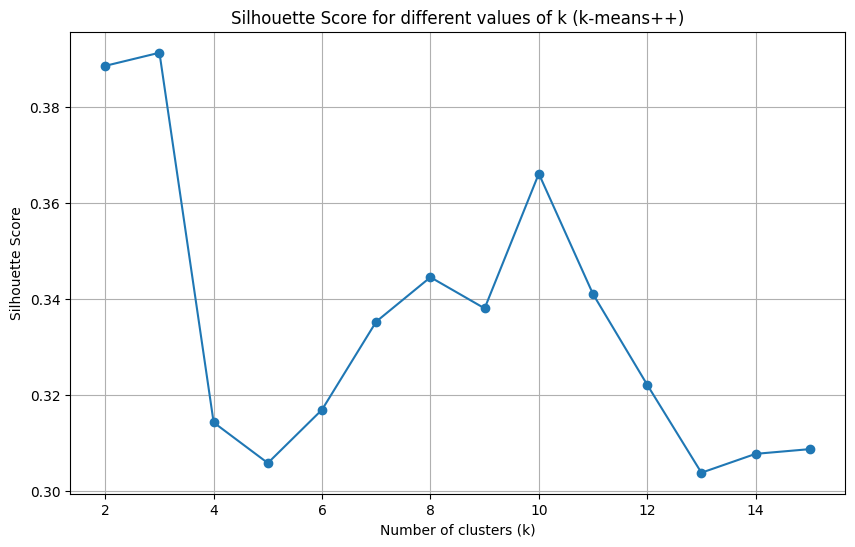

Cluster 0: 11599 elements
Cluster 1: 38401 elements
Silhouette score for k=2: 0.3887178613793968
Cluster 0: 33328 elements
Cluster 1: 11442 elements
Cluster 2: 5230 elements
Silhouette score for k=3: 0.3905605184205316
Cluster 0: 18451 elements
Cluster 1: 10019 elements
Cluster 2: 4207 elements
Cluster 3: 17323 elements
Silhouette score for k=4: 0.31435439791319963
Cluster 0: 6202 elements
Cluster 1: 14883 elements
Cluster 2: 7643 elements
Cluster 3: 4153 elements
Cluster 4: 17119 elements
Silhouette score for k=5: 0.3056871993676307
Cluster 0: 5754 elements
Cluster 1: 5659 elements
Cluster 2: 4185 elements
Cluster 3: 15456 elements
Cluster 4: 14487 elements
Cluster 5: 4459 elements
Silhouette score for k=6: 0.3195690394364823
Cluster 0: 1192 elements
Cluster 1: 14328 elements
Cluster 2: 4546 elements
Cluster 3: 3942 elements
Cluster 4: 5414 elements
Cluster 5: 15201 elements
Cluster 6: 5377 elements
Silhouette score for k=7: 0.32935282310755626
Cluster 0: 4357 elements
Cluster 1: 4800

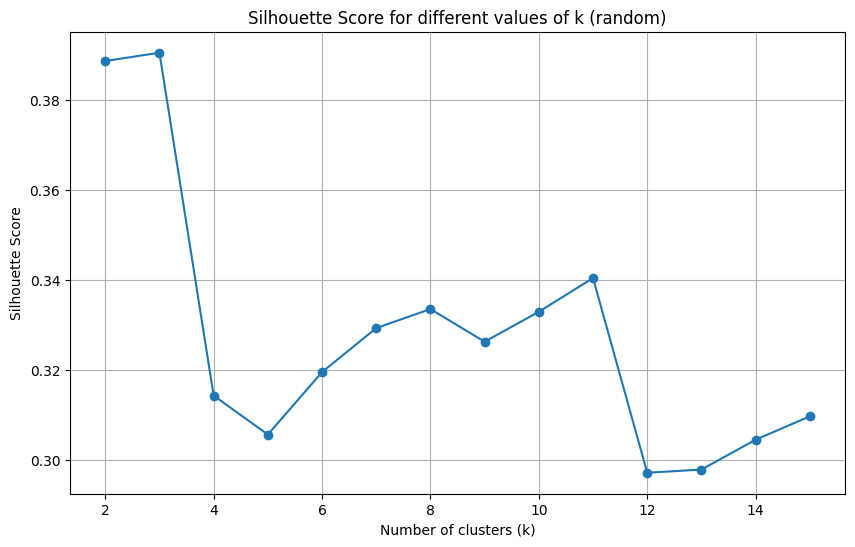

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def grid_search_kmeans(X, k_range, init_method='k-means++'):
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init=init_method, n_init=10, random_state=42)
        cluster_assignments = kmeans.fit_predict(X)

        # Count the number of elements in each cluster
        cluster_counts = Counter(cluster_assignments)

        # Print the number of elements in each cluster
        for cluster_id, count in sorted(cluster_counts.items()):
            print(f"Cluster {cluster_id}: {count} elements")

        score = silhouette_score(X, cluster_assignments)
        silhouette_scores.append(score)
        print(f"Silhouette score for k={k}: {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score for different values of k ({init_method})')
    plt.grid(True)
    plt.show()

    return silhouette_scores

# Define the range of k values
k_range = range(2, 12)

# Assuming X is your dataset loaded as a numpy array
# Example: X = np.array([...])

# Perform grid search and plot silhouette scores for k-means++
silhouette_scores_kmeans_plus_plus = grid_search_kmeans(X, k_range, init_method='k-means++')

# Perform grid search and plot silhouette scores for standard k-means
silhouette_scores_kmeans = grid_search_kmeans(X, k_range, init_method='random')

In [ ]:
dataset.columns

Index(['Start_datetime', 'End_datetime', 'Volume (kWh)', 'max P per EVSE (kW)',
       'Dur_float', 'Charging_time', 'Idle_time'],
      dtype='object')


For k=2:

Cluster 0:
  Centroid:
    Start_datetime: 0.02
    End_datetime: -0.01
    Volume (kWh): -0.13
    max P per EVSE (kW): 0.07
    Dur_float: -0.26
    Charging_time: -0.23
    Idle_time: -0.26
  Size: 44380
  Feature distributions:
    Start_datetime:
      Mean: 0.47
      Std: 0.18
      Min: 0.00
      Max: 1.00
    End_datetime:
      Mean: 0.35
      Std: 0.10
      Min: 0.00
      Max: 0.66
    Volume (kWh):
      Mean: 0.14
      Std: 0.15
      Min: 0.00
      Max: 1.00
    max P per EVSE (kW):
      Mean: 0.16
      Std: 0.25
      Min: 0.00
      Max: 1.00
    Dur_float:
      Mean: 0.05
      Std: 0.04
      Min: 0.00
      Max: 0.26
    Charging_time:
      Mean: 0.08
      Std: 0.07
      Min: 0.00
      Max: 0.38
    Idle_time:
      Mean: 0.05
      Std: 0.04
      Min: 0.00
      Max: 0.26

Cluster 1:
  Centroid:
    Start_datetime: -0.12
    End_datetime: 0.04
    Volume (kWh): 1.02
    max P per EVSE (kW): -0.55
    Dur_float: 2.07
    Charging_time: 1.86
 

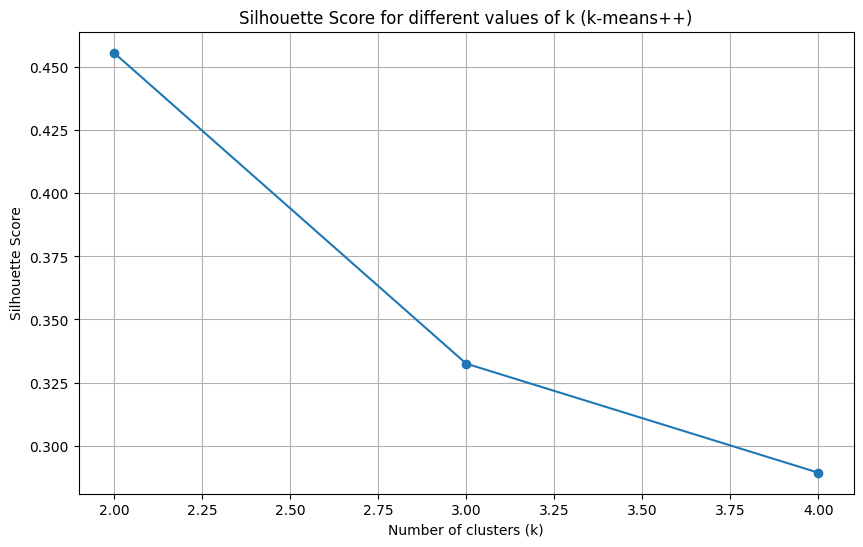

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def describe_clusters(X, kmeans, feature_names):
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    for i in range(len(centroids)):
        print(f"\nCluster {i}:")

        # Centroid values
        print("  Centroid:")
        for j, value in enumerate(centroids[i]):
            print(f"    {feature_names[j]}: {value:.2f}")

        # Cluster size
        cluster_size = np.sum(labels == i)
        print(f"  Size: {cluster_size}")

        # Feature distributions within the cluster
        cluster_points = X[labels == i]
        print("  Feature distributions:")
        for j, feature in enumerate(feature_names):
            values = cluster_points[:, j]
            print(f"    {feature}:")
            print(f"      Mean: {np.mean(values):.2f}")
            print(f"      Std: {np.std(values):.2f}")
            print(f"      Min: {np.min(values):.2f}")
            print(f"      Max: {np.max(values):.2f}")

def grid_search_kmeans(X, k_range, feature_names, init_method='random'): #'k-means++'):
    """

    Args:
      X:
      k_range:
      feature_names:
      init_method:

    Returns:
    silhouette_scores:
    """
    silhouette_scores = []
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init=init_method, n_init=10, random_state=42)
        cluster_assignments = kmeans.fit_predict(X_scaled)

        print(f"\nFor k={k}:")
        describe_clusters(X, kmeans, feature_names)

        score = silhouette_score(X_scaled, cluster_assignments)
        silhouette_scores.append(score)
        print(f"Silhouette score: {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score for different values of k ({init_method})')
    plt.grid(True)
    plt.show()

    return silhouette_scores

# Define the range of k values
k_range = range(2, 5)  # Reduced range for brevity

# Assuming X is your dataset loaded as a numpy array
# Example: X = np.array([...])

# Define feature names
feature_names = ['Start_datetime', 'End_datetime', 'Volume (kWh)', 'max P per EVSE (kW)',
       'Dur_float', 'Charging_time', 'Idle_time']  # Replace with your actual feature names

# Perform grid search and plot silhouette scores
silhouette_scores = grid_search_kmeans(X, k_range, feature_names, init_method='k-means++')

Cluster 0: 33875 elements
Cluster 1: 16125 elements
Silhouette score for k=2: 0.355263459048536
Cluster 0: 33356 elements
Cluster 1: 11444 elements
Cluster 2: 5200 elements
Silhouette score for k=3: 0.39104805042268337
Cluster 0: 18431 elements
Cluster 1: 17300 elements
Cluster 2: 10008 elements
Cluster 3: 4261 elements
Silhouette score for k=4: 0.3142545456343523
Cluster 0: 17121 elements
Cluster 1: 4451 elements
Cluster 2: 18309 elements
Cluster 3: 5906 elements
Cluster 4: 4213 elements
Silhouette score for k=5: 0.3053762750331484
Cluster 0: 16552 elements
Cluster 1: 6074 elements
Cluster 2: 5865 elements
Cluster 3: 14168 elements
Cluster 4: 4406 elements
Cluster 5: 2935 elements
Silhouette score for k=6: 0.2763599664730804
Cluster 0: 16455 elements
Cluster 1: 3372 elements
Cluster 2: 1651 elements
Cluster 3: 6698 elements
Cluster 4: 5942 elements
Cluster 5: 14595 elements
Cluster 6: 1287 elements
Silhouette score for k=7: 0.33085728499000333
Cluster 0: 5693 elements
Cluster 1: 12798

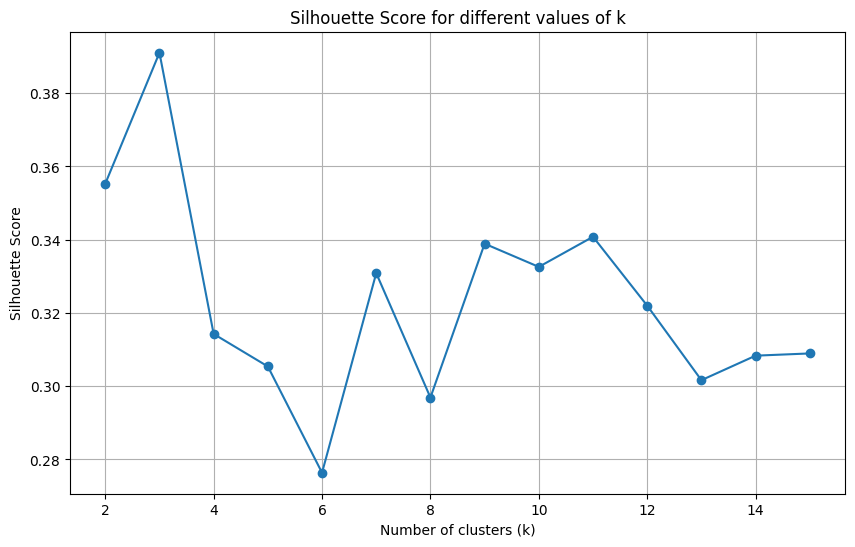

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def grid_search_kmeans(X, k_range):
    silhouette_scores = []
    for k in k_range:
        initial_centroids = kmeans_plus_plus(X, k)
        final_centroids, cluster_assignments = kmeans(X, initial_centroids)

        # Count the number of elements in each cluster
        cluster_counts = Counter(cluster_assignments)

        # Print the number of elements in each cluster
        for cluster_id, count in sorted(cluster_counts.items()):
            print(f"Cluster {cluster_id}: {count} elements")

        score = silhouette_score(X, cluster_assignments)
        silhouette_scores.append(score)
        print(f"Silhouette score for k={k}: {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for different values of k')
    plt.grid(True)
    plt.show()

    return silhouette_scores

# Define the range of k values
k_range = range(2, 16)

# Assuming X is your dataset loaded as a numpy array
# Example: X = np.array([...])

# Perform grid search and plot silhouette scores
silhouette_scores = grid_search_kmeans(X, k_range)


OTHER IMPLEMENTATION

In [ ]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)


In [ ]:
from sklearn_extra.cluster import KMedoids

# Run K-Medoids Using the Known Medoids
kmedoids = KMedoids(n_clusters=7, init='random', random_state=42)
kmedoids.fit(data)

# Get labels and cluster centers (medoids)
labels_kmedoids = kmedoids.labels_
medoids = kmedoids.cluster_centers_

# Calculate Evaluation Metrics
silhouette_avg_kmedoids = silhouette_score(X, labels_kmedoids)
calinski_harabasz_avg_kmedoids = calinski_harabasz_score(X, labels_kmedoids)
davies_bouldin_avg_kmedoids = davies_bouldin_score(X, labels_kmedoids)

# Output the results
medoids, silhouette_avg_kmedoids, calinski_harabasz_avg_kmedoids, davies_bouldin_avg_kmedoids